# Curb allocation

In [1]:
import pandas as pd
import athena
import os
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [2]:
TNC = 0.30  #percent of TNC from standard

def get_dataframe(freq):
    traffic = athena.traffic.read_cache(freq)
    sub = traffic.query("usage=='terminal'").pivot_table(index='entry_time', 
                                                   columns='group', 
                                                   values='count', 
                                                   aggfunc='sum')

    sub = sub[['courtesy', 'shared_ride', 'standard', 'taxi']]
    sub['ride_app'] = sub['standard']*TNC
    sub['passenger_drop_pick'] = sub['standard']*(1-TNC)
    del sub['standard']
    sub.index = pd.to_datetime(sub.index)
    return sub

curb = pd.read_csv("curb_by_terminal.csv")
curb.set_index('kind', inplace=True)

# terminal percent
terminals = pd.DataFrame({'terminals': ['A', 'B', 'C', 'D', 'E'],
                          'percent': [ 0.28, 0.13, 0.29, 0.145, 0.145 ]})

# slots
slots_by_kind_terminal = curb/30
slots_by_kind = curb.sum(axis=1)/30   
slots = curb.sum().sum()/30

In [3]:
sub = get_dataframe("30min")
df = sub.reset_index().melt(id_vars='entry_time')

for terminal in terminals.to_dict(orient='records'):
    df[terminal['terminals']] = df['value']*terminal['percent']
    
del df['value']
df = df.melt(id_vars=['entry_time', 'group'])

## Slots by terminal and group

In [4]:
t = (slots_by_kind_terminal.reset_index()
        .melt(id_vars='kind')
        .rename(columns={'kind': 'group', 'value': 'slots'}))
merged = pd.merge(df, t, on=['group', 'variable'])
merged['metric'] = merged['value'].divide(merged['slots'])/6 # 5 minutes

In [5]:
merged.head()
merged['xvalue'] = merged['group']+ ":" +merged['variable']
merged['name'] = "Slots by term and group"

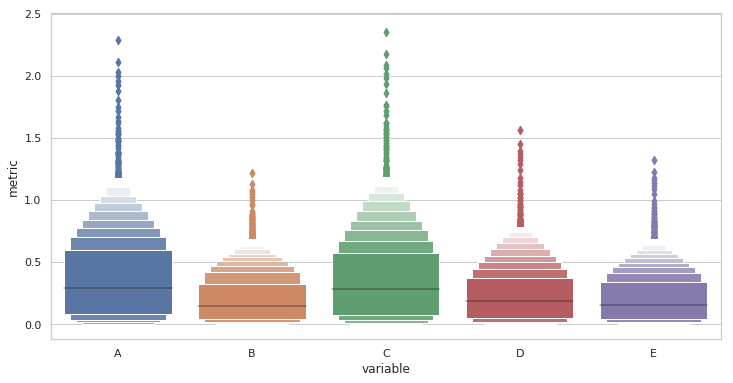

In [6]:
f, ax = plt.subplots(figsize=(12,6))
sns.boxenplot(x="variable", y="metric",
              scale="linear", data=merged, ax=ax)

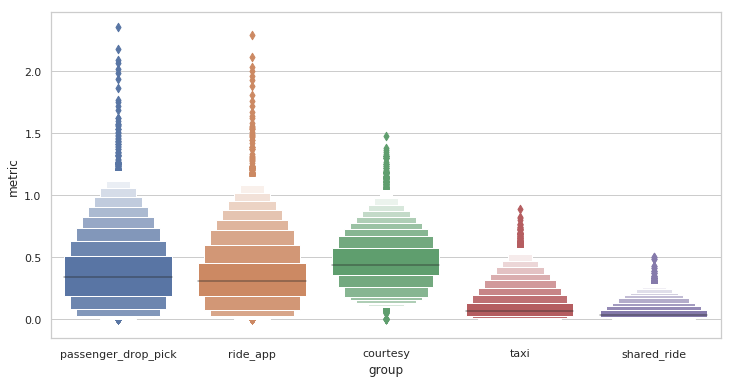

In [7]:
order = ['passenger_drop_pick', 'ride_app', 'courtesy', 'taxi', 'shared_ride']
f, ax = plt.subplots(figsize=(12,6))
sns.boxenplot(x="group", y="metric",
              order=order,
              scale="linear", data=merged, ax=ax)

## Slots by group, park at any terminal

In [8]:
merged2 = pd.merge(df.groupby(['entry_time', 'group']).sum().reset_index(), 
                   pd.DataFrame(slots_by_kind).rename(columns={0:'slots'}).reset_index(), 
         left_on='group', right_on='kind')
merged2['metric'] = merged2['metric'] = merged2['value'].divide(merged2['slots'])/6
merged2['name'] = "Slots by group"

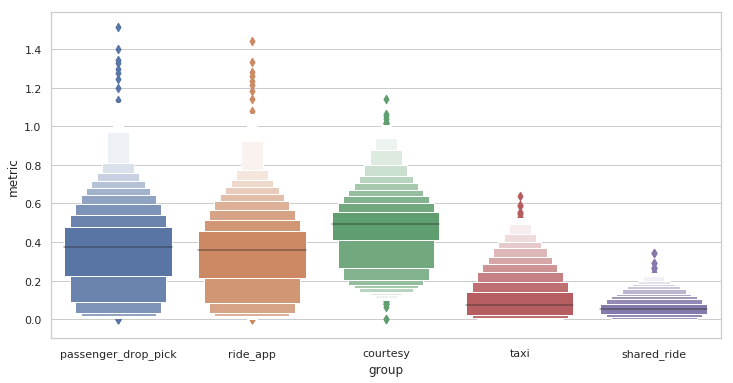

In [9]:
f, ax = plt.subplots(figsize=(12,6))
sns.boxenplot(x="group", y="metric",
              order=order,
              scale="linear", data=merged2, ax=ax)

## No assignment at the Terminal

In [10]:
t = (slots_by_kind_terminal.reset_index()
        .melt(id_vars='kind')
        .rename(columns={'kind': 'group', 'value': 'slots'})
        .groupby('variable').sum().reset_index())

In [11]:
merged3 = pd.merge(df.groupby(['entry_time', 'variable']).sum().reset_index(), t, 
         left_on='variable', right_on='variable')
merged3['metric'] = merged3['metric'] = merged3['value'].divide(merged3['slots'])/6
merged3['name'] = "Slots by term"

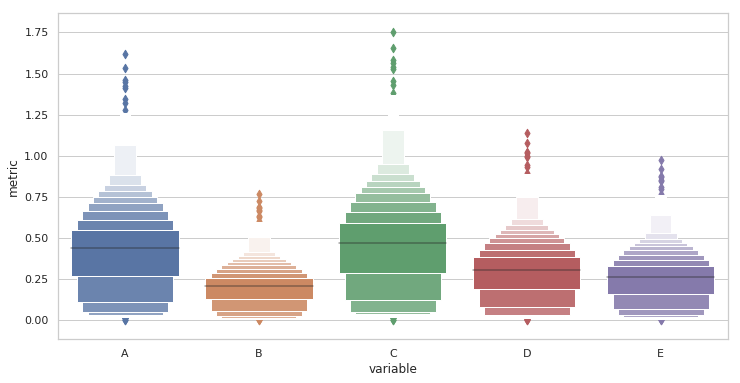

In [12]:
f, ax = plt.subplots(figsize=(12,6))
sns.boxenplot(x="variable", y="metric",
              scale="linear", data=merged3, ax=ax)

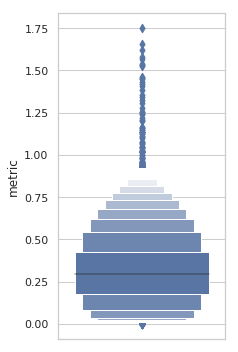

In [13]:
f, ax = plt.subplots(figsize=(3,6))
sns.boxenplot(y="metric",
              scale="linear", data=merged3, ax=ax)

### Free for all 

In [14]:
merged4 = df.groupby(['entry_time']).sum().reset_index()
merged4['metric'] = merged4['value']/slots/6
merged4['name'] = "Slots"

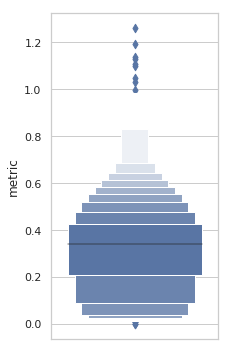

In [15]:
f, ax = plt.subplots(figsize=(3,6))
sns.boxenplot(y="metric",
              scale="linear", data=merged4, ax=ax)

In [16]:
comb = pd.concat([merged[['entry_time', 'name', 'metric']],
           merged2[['entry_time', 'name', 'metric']],
           merged3[['entry_time', 'name', 'metric']],
           merged4[['entry_time', 'name', 'metric']]])

Text(0.5, 1.0, 'Number of cars per slot per 5 minutes')

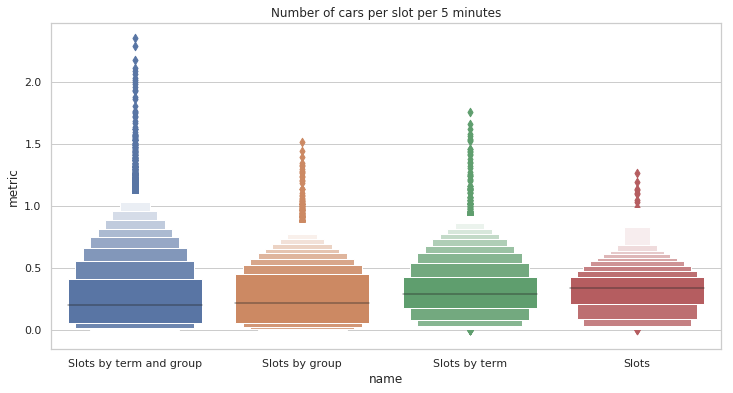

In [17]:
f, ax = plt.subplots(figsize=(12,6))
sns.boxenplot(y="metric", x='name',
              scale="linear", data=comb, ax=ax)
ax.set_title("Number of cars per slot per 5 minutes")